# 0. Install dependencies

In [1]:
 #%pip install matplotlib tensorflow==2.5.0 tensorflow-io==0.19.1 

# 1. Import depndencies 

In [2]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf 
import tensorflow_io as tfio

In [3]:
print("tensorflow version:", tf.__version__)
print("tensorflow_io version:", tfio.__version__)

tensorflow version: 2.5.0
tensorflow_io version: 0.19.1


# 2. Loading data

In [4]:
# Here we are loding only one file for testing purpose

CRY_FILE = os.path.join('data', 'cry', 'baby_cry (366).wav')
NOT_CRY_FILE = os.path.join('data', 'not_cry', 'noise (149).wav')

In [5]:
print(CRY_FILE)
print(NOT_CRY_FILE)

data\cry\baby_cry (366).wav
data\not_cry\noise (149).wav


# 3. Data loading function

In [6]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

# 4. Plotting waveform

In [7]:
wave = load_wav_16k_mono(CRY_FILE)
nwave = load_wav_16k_mono(NOT_CRY_FILE)

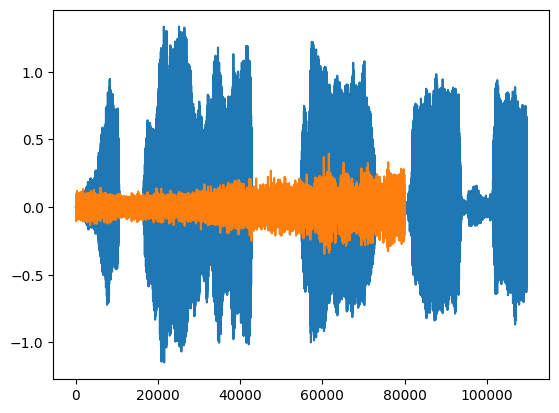

In [8]:
plt.plot(wave) # Blue waveform
plt.plot(nwave) # Orange waveform
plt.show()

# 5. Creating Tensorflow Dataset

In [9]:
# Defining paths to positive and negative data

POS = os.path.join('data', 'cry')
NEG = os.path.join('data', 'not_cry')

In [10]:
# Create Tensorflow Dataset

pos = tf.data.Dataset.list_files(POS+'\*.wav')
neg = tf.data.Dataset.list_files(NEG+'\*.wav')

In [11]:
pos.as_numpy_iterator().next()

b'data\\cry\\baby_cry (335).wav'

In [12]:
neg.as_numpy_iterator().next()

b'data\\not_cry\\silence (82).wav'

In [13]:
# Add labels and Combine Positive and Negative Samples

positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

In [14]:
data.as_numpy_iterator().next()

(b'data\\cry\\baby_cry (340).wav', 1.0)

# 6. Determine Average Length of a Cry files

In [15]:
# Calculate Wave Cycle Length

lengths = []
for file in os.listdir(os.path.join('data', 'cry')):
    tensor_wave = load_wav_16k_mono(os.path.join('data', 'cry', file))
    lengths.append(len(tensor_wave))

In [16]:
lengths

[109440,
 107520,
 110720,
 111360,
 110720,
 110720,
 111040,
 112000,
 112000,
 112000,
 104640,
 104640,
 111040,
 112000,
 112000,
 112000,
 112000,
 112000,
 110720,
 110720,
 111040,
 111040,
 112000,
 110400,
 112000,
 112000,
 112000,
 112000,
 112000,
 106560,
 112000,
 109760,
 110080,
 111360,
 111360,
 110080,
 110720,
 109760,
 109760,
 111040,
 108480,
 111360,
 112000,
 111360,
 112960,
 111040,
 112960,
 112960,
 112960,
 112960,
 112960,
 112960,
 112640,
 112960,
 112000,
 112000,
 107520,
 112000,
 112000,
 112000,
 110400,
 110720,
 112000,
 112000,
 106560,
 105920,
 106560,
 106880,
 106880,
 112000,
 111040,
 111040,
 111360,
 112000,
 112000,
 112000,
 112000,
 110400,
 106560,
 112000,
 112640,
 112960,
 112640,
 108480,
 112000,
 112000,
 112000,
 112000,
 108480,
 112000,
 108480,
 111360,
 110720,
 110720,
 110080,
 109760,
 112640,
 112960,
 110400,
 112000,
 112000,
 112960,
 112960,
 111040,
 110400,
 112000,
 112000,
 109760,
 110080,
 109760,
 109760,
 

In [17]:
# Calculate Mean, Min and Max

mean_cry = tf.math.reduce_mean(lengths)
min_cry = tf.math.reduce_min(lengths)
max_cry = tf.math.reduce_max(lengths)

In [18]:
print(mean_cry)
print(min_cry)
print(max_cry)

tf.Tensor(106768, shape=(), dtype=int32)
tf.Tensor(80000, shape=(), dtype=int32)
tf.Tensor(112960, shape=(), dtype=int32)


# 7. Build Preprocessing Function to Convert to Spectrogram

In [19]:
# Preprocessing function

def preprocess(file_path, label): 
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

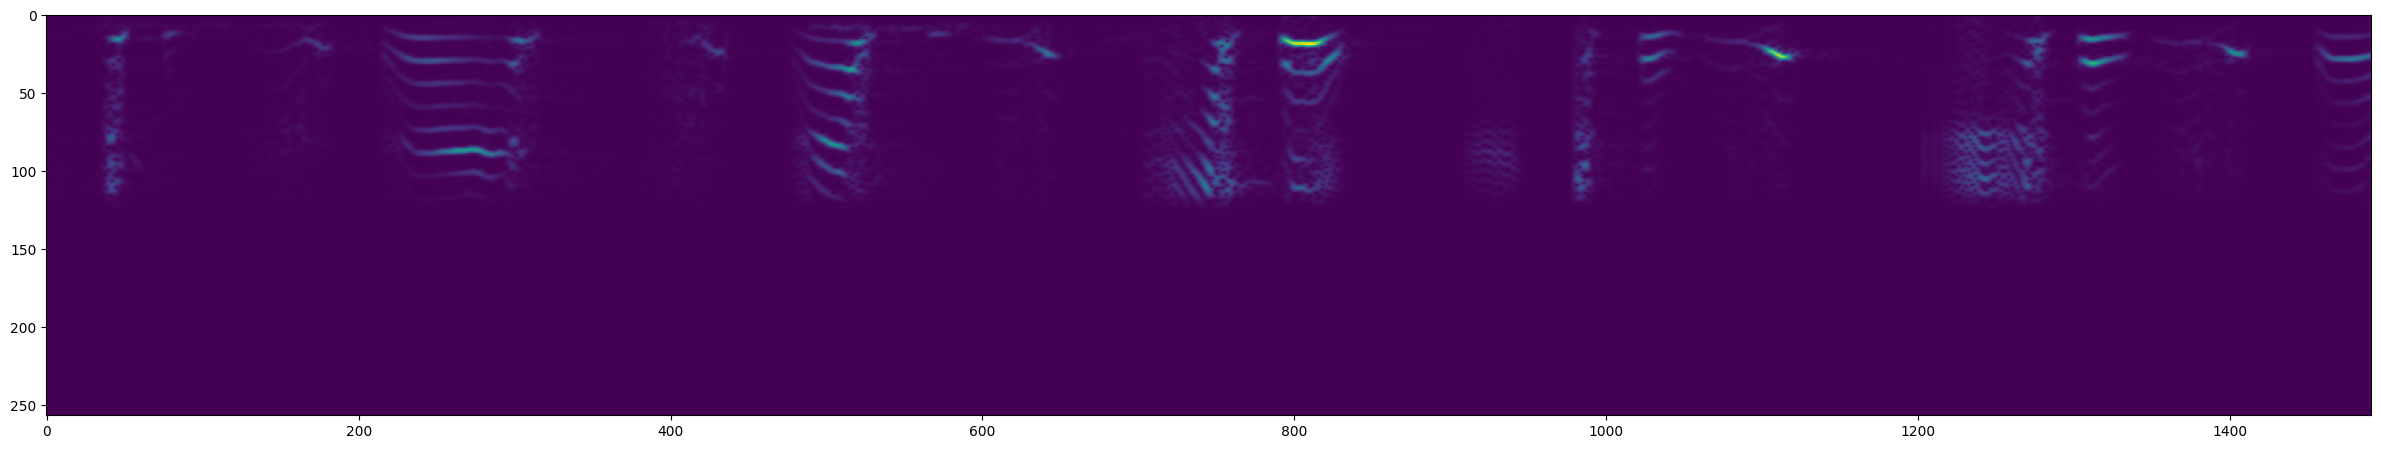

In [20]:
# Testing Out the Function and Vizulazing the Spectrogram for positives

filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectrogram, label = preprocess(filepath, label)

plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

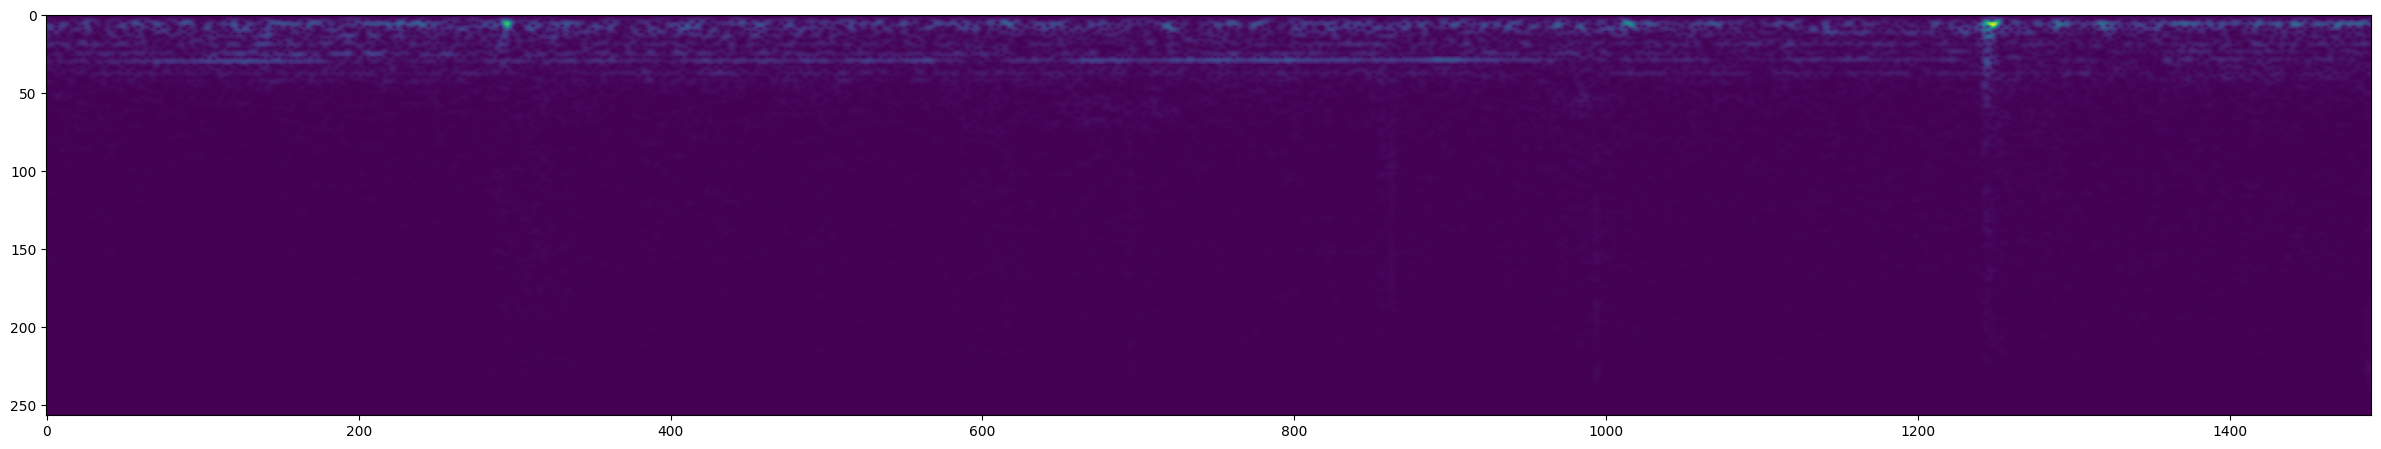

In [21]:
# Testing Out the Function and Vizulazing the Spectrogram for negatives

filepath, label = negatives.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectrogram, label = preprocess(filepath, label)

plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

# 8. Creating Training and Testing Partitions of Data

In [22]:
# Creating Tensorflow data pipeline

data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


In [23]:
len (data)

53

In [24]:
# Splitting into  Tranining and Testing Partitions

train = data.take(37) # So 70% of data for training purpose
test = data.skip(37).take(16) # So 30% data for testing purpose

In [25]:
# Test one batch

samples, labels = train.as_numpy_iterator().next()
samples.shape


(16, 1491, 257, 1)

# 9. Build Deep Learning Model

In [26]:
# Loading Tensorflow Dependencies

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

In [27]:
# Building sequential mode

model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(1491, 257,1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [28]:
# Compiling the model

model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])


In [29]:
# Viewing summary

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1489, 255, 16)     160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1487, 253, 16)     2320      
_________________________________________________________________
flatten (Flatten)            (None, 6019376)           0         
_________________________________________________________________
dense (Dense)                (None, 128)               770480256 
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 770,482,865
Trainable params: 770,482,865
Non-trainable params: 0
_________________________________________________________________


In [67]:
# Fitting(training) Model

hist = model.fit(train, epochs=4, validation_data=test)

Epoch 1/4
37/37 [==============================] - 594s 16s/step - loss: 17.0934 - recall_1: 0.8529 - precision_1: 0.8201 - val_loss: 0.5054 - val_recall_1: 0.5860 - val_precision_1: 0.9200
Epoch 2/4
37/37 [==============================] - 513s 14s/step - loss: 0.2756 - recall_1: 0.9293 - precision_1: 0.9441 - val_loss: 0.1003 - val_recall_1: 0.9745 - val_precision_1: 0.9808
Epoch 3/4
37/37 [==============================] - 568s 15s/step - loss: 0.0978 - recall_1: 0.9839 - precision_1: 0.9633 - val_loss: 0.0319 - val_recall_1: 0.9872 - val_precision_1: 1.0000
Epoch 4/4
37/37 [==============================] - 523s 14s/step - loss: 0.0312 - recall_1: 0.9919 - precision_1: 0.9973 - val_loss: 0.0301 - val_recall_1: 0.9939 - val_precision_1: 0.9939


AttributeError: 'CheckpointLoadStatus' object has no attribute 'history'

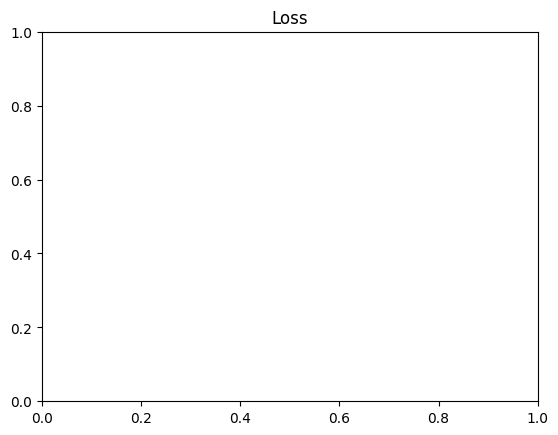

In [33]:
# Plotting the loss

plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

In [75]:
hist.history

{'loss': [17.093414306640625,
  0.2756289541721344,
  0.09777791053056717,
  0.03124542534351349],
 'recall_1': [0.8529411554336548,
  0.9293193817138672,
  0.9839141964912415,
  0.9918919205665588],
 'precision_1': [0.8200514316558838,
  0.9441489577293396,
  0.9632545709609985,
  0.9972826242446899],
 'val_loss': [0.5053936839103699,
  0.10026784241199493,
  0.031882766634225845,
  0.030111011117696762],
 'val_recall_1': [0.5859872698783875,
  0.9745222926139832,
  0.9871794581413269,
  0.9939024448394775],
 'val_precision_1': [0.9200000166893005,
  0.9807692170143127,
  1.0,
  0.9939024448394775]}

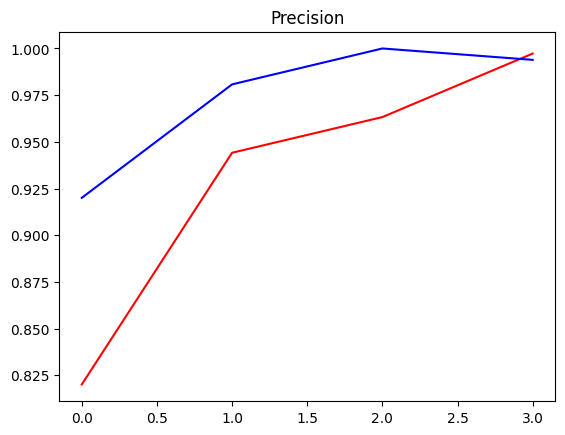

In [76]:
# Plotting the precision

plt.title('Precision')
plt.plot(hist.history['precision_1'], 'r')
plt.plot(hist.history['val_precision_1'], 'b')
plt.show()

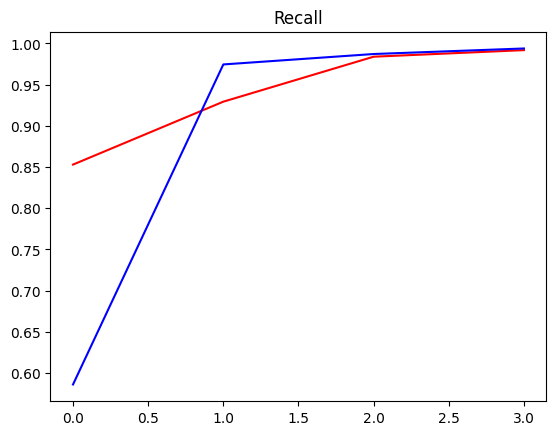

In [77]:
# Plotting the recall

plt.title('Recall')
plt.plot(hist.history['recall_1'], 'r')
plt.plot(hist.history['val_recall_1'], 'b')
plt.show()

In [78]:
model.save('baby_cry_model.ckpt')

INFO:tensorflow:Assets written to: baby_cry_model.ckpt\assets


# Loading Saved Model

In [27]:
from tensorflow import keras
model = keras.models.load_model('baby_cry_model.ckpt')

# 10. Make a Prediction on a Single Clip

In [35]:
# Taking One Batch and Making a Prediction

X_test, y_test = test.as_numpy_iterator().next()

In [36]:
yhat = model.predict(X_test)

In [37]:
# Convert Logits to Classes

yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

In [38]:
tf.math.reduce_sum(yhat) # Clips which are tagged as baby crying

<tf.Tensor: shape=(), dtype=int32, numpy=11>

In [39]:
tf.math.reduce_sum(y_test) # Actual number of clips in which baby is crying

<tf.Tensor: shape=(), dtype=float32, numpy=11.0>

In [40]:
yhat # Array of Predicted Result

[0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1]

In [41]:
y_test.astype(int) # Actual Result

array([0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1])

In [ ]:
# just for testing